# **PyTorch**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
file_path = '/content/drive/MyDrive/DL/DLWeek2/compressed_data.csv'
data = pd.read_csv(file_path)

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [31]:
# Adjust target labels to start from 0 if necessary
y = data['Cover_Type'] - 1  # Reduce 1 from each label to start from 0

# Prepare the data
X = data.drop(columns=['Cover_Type'])

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for mini-batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [33]:
# Build the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# Automatically use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the selected device
model = MLP(input_dim=X_train.shape[1], output_dim=len(y.unique())).to(device)

# Reinitialize the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
# Train the model
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Move data to the selected device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.2f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
    y_pred_tensor = model(X_test_tensor)
    _, y_pred = torch.max(y_pred_tensor, 1)


Epoch 2/10, Loss: 3959.16
Epoch 4/10, Loss: 3632.94
Epoch 6/10, Loss: 3503.27
Epoch 8/10, Loss: 3416.53
Epoch 10/10, Loss: 3373.37


Accuracy: 0.8398
Precision: 0.8404
Recall: 0.8398
F1 Score: 0.8367
AUC: 0.9546


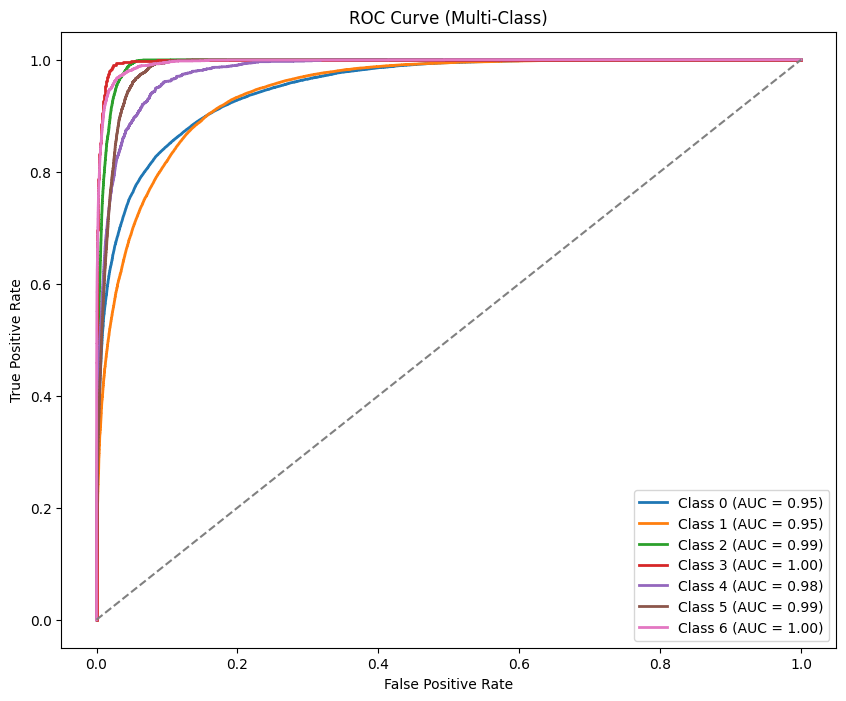

In [35]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Fix for AUC calculation by detaching the tensor and converting to numpy
roc_auc = roc_auc_score(y_test, model(X_test_tensor).softmax(dim=1).detach().numpy(), multi_class='ovr', average='weighted')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

# ROC Curve
# Get the predicted probabilities for each class (softmax output)
y_pred_prob = model(X_test_tensor).softmax(dim=1).detach().numpy()

# Calculate ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_pred_prob.shape[1]):  # Iterate over each class
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score(y_test == i, y_pred_prob[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_pred_prob.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-Class)')
plt.legend(loc='lower right')
plt.show()

# **Tensorflow**

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [27]:
file_path = '/content/drive/MyDrive/DL/DLWeek2/compressed_data.csv'
data = pd.read_csv(file_path)

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [28]:
# Adjust target labels to start from 0 if necessary
y = data['Cover_Type'] - 1  # Reduce 1 from each label to start from 0

# Prepare the data
X = data.drop(columns=['Cover_Type'])

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
# Build the MLP model using TensorFlow/Keras
model = models.Sequential([
    layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(y.unique()), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6975 - loss: 0.7212 - val_accuracy: 0.7740 - val_loss: 0.5193
Epoch 2/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7576 - loss: 0.5585 - val_accuracy: 0.7957 - val_loss: 0.4788
Epoch 3/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7737 - loss: 0.5241 - val_accuracy: 0.8101 - val_loss: 0.4476
Epoch 4/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7842 - loss: 0.5045 - val_accuracy: 0.8183 - val_loss: 0.4356
Epoch 5/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7903 - loss: 0.4928 - val_accuracy: 0.8234 - val_loss: 0.4240
Epoch 6/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7950 - loss: 0.4838 - val_accuracy: 0.8316 - val_loss: 0.4127
Epoch 7/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7983 - loss: 0.4783 - val_accuracy: 0.8343 - val_loss: 0.4077
Epoch 8/10
7263/7263 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8007 - loss: 0

Accuracy: 0.8376
Precision: 0.8374
Recall: 0.8376
F1 Score: 0.8353
AUC: 0.9529


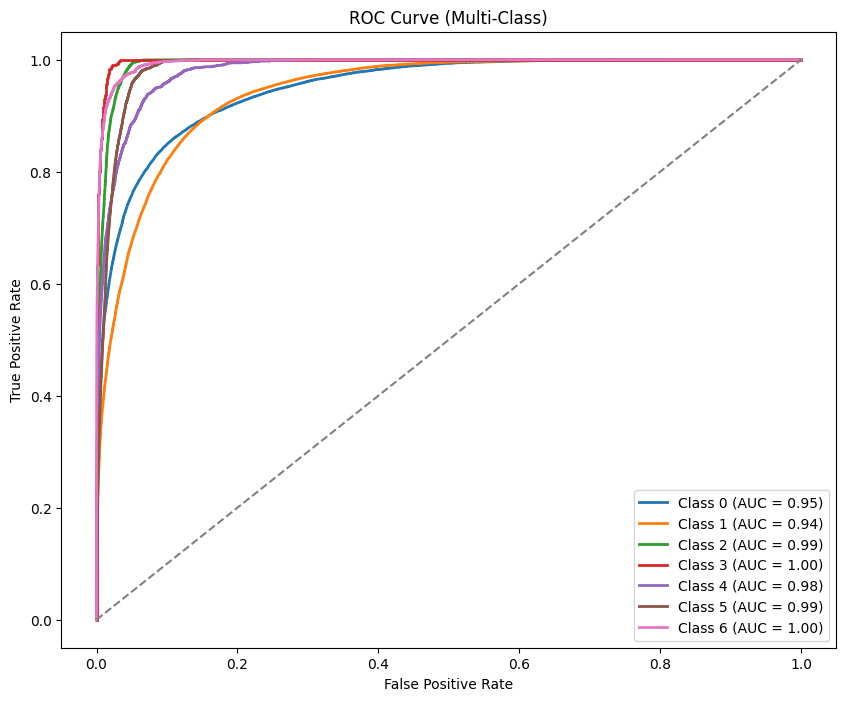

In [20]:
# Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# AUC Calculation
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

# ROC Curve
# Calculate ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_pred.shape[1]):  # Iterate over each class
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score(y_test == i, y_pred[:, i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_pred.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-Class)')
plt.legend(loc='lower right')
plt.show()